# Auto Encoder

## 符号定义

|符号|含义|
|:--:|:--:|
|$\pmb{x}$|输入数据|
|$\pmb{y}$|输出数据|
|$\pmb{h}$|低维表示向量|
|$f_{w, b}$|映射函数|
|$g_{w, b}$|映射函数|
|$\mathcal{L}$|损失函数|
|$m$|特征空间维度|

## 概念

Auto Encoder通常是一个多层前馈网络。为了实现可靠的监督学习，在参数学习阶段需要编码器和解码器两部分。其中编码器将输入数据映射到低维特征空间，解码器又将低维特征映射回原空间。通过对输入输出进行监督实现参数学习。这个学习过程的损失可由下式表示

$$
\begin{equation}
    \begin{split}
    \mathcal{L} 
    &= \sum_{i=1}^N||\pmb{x_i}-\pmb{y_i}||^2 \\
    &= \sum_{i=1}^N||\pmb{x_i}-g_{w, b}(f_{w, b}(\pmb{x_i}))||^2
    \end{split}
\end{equation}
$$

其中，$g_{w, b}$为解码器拟合得到的函数，$f_{w, b}$为编码器拟合得到的函数。

上式中的$f_{w, b}$即为Auto Encoder，它能实现将输入数据嵌入映射到低维特征空间。

$$
\begin{equation}
    \pmb{h_i} = f_{w, b}(\pmb{x_i}), \pmb{h_i} \in \mathcal{R}^m
\end{equation}
$$

上式并没指出输入数据所在的空间，根据输入数据类型不同完全可以定义不同的编码器形式。

## 算法步骤

1. 根据输入数据设计相应的编码器结构和解码器结构
2. 利用输入输出监督训练编码器和解码器
3. 得到编码器用于降维

In [1]:
from collections import OrderedDict
import numpy as np
import random

import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


In [2]:
# ------------------------ model ------------------------ 

class MyAE(nn.Module):

    def __init__(self):

        super(MyAE, self).__init__()

        self.encoder = nn.Sequential(OrderedDict({
            "linear1": nn.Linear(28*28, 128),
            "BN1": nn.BatchNorm1d(128),
            "ReLU1": nn.ReLU(inplace=True),
            "linear2": nn.Linear(128, 64),
            "BN2": nn.BatchNorm1d(64),
            "ReLU2": nn.ReLU(inplace=True),
            "linear3": nn.Linear(64, 32),
            "BN3": nn.BatchNorm1d(32),
            "ReLU3": nn.ReLU(inplace=True),
            "linear4": nn.Linear(32, 8),
            "BN4": nn.BatchNorm1d(8),
            "ReLU4": nn.ReLU(inplace=True),
            "linear5": nn.Linear(8, 2),
        }))

        self.decoder = nn.Sequential(OrderedDict({
            "linear1": nn.Linear(2, 8),
            "BN1": nn.BatchNorm1d(8),
            "ReLU1": nn.ReLU(inplace=True),
            "linear2": nn.Linear(8, 32),
            "BN2": nn.BatchNorm1d(32),
            "ReLU2": nn.ReLU(inplace=True),
            "linear3": nn.Linear(32, 64),
            "BN3": nn.BatchNorm1d(64),
            "ReLU3": nn.ReLU(inplace=True),
            "linear4": nn.Linear(64, 128),
            "BN4": nn.BatchNorm1d(128),
            "ReLU4": nn.ReLU(inplace=True),
            "linear5": nn.Linear(128, 28*28),
            "sigmoid": nn.Sigmoid()
        }))
    
    def forward(self, x):
        feature_vector = self.encoder(x)
        output_ = self.decoder(feature_vector)
        return output_
    
    def encoder_func(self, x):
        return self.encoder(x)
    
    def decoder_func(self, x):
        return self.decoder(x)

In [3]:
# --------------------- global ------------------
np.random.seed(1024)
torch.manual_seed(1024)
random.seed(1024)

if torch.cuda.is_available():
    torch.cuda.manual_seed(1024)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("device: ", device)

batch_size = 128
basic_lr = 5e-3
epochs = 1

# ------------------------ data ------------------------ 
transform_ = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST('./mnist', train=True, transform=transform_, download=True)
test_data = datasets.MNIST('./mnist', train=False, transform=transform_)

train_data_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# ------------------------ model -------------------------
model = MyAE().to(device)

# ----------------------- optimizer and loss -----------------------
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=basic_lr)

# ------------------------ train ----------------------
for epoch in range(1, epochs+1):
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.reshape(-1, 28*28).to(device)

        output_ = model(images)

        train_loss = loss_func(images, output_)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if i % 200 == 0:
            print("[{}/{}]\t[{}/{}]\ttrain loss:{:.4f}".format(epoch, epochs, i, len(train_data_loader), train_loss.item()))
    print("[{}/{}]\t[{}/{}]\ttrain loss:{:.4f}".format(epoch, epochs, len(train_data_loader), len(train_data_loader), train_loss.item()))

device:  cuda
[1/1]	[0/469]	train loss:0.2405
[1/1]	[200/469]	train loss:0.0429
[1/1]	[400/469]	train loss:0.0442
[1/1]	[469/469]	train loss:0.0470


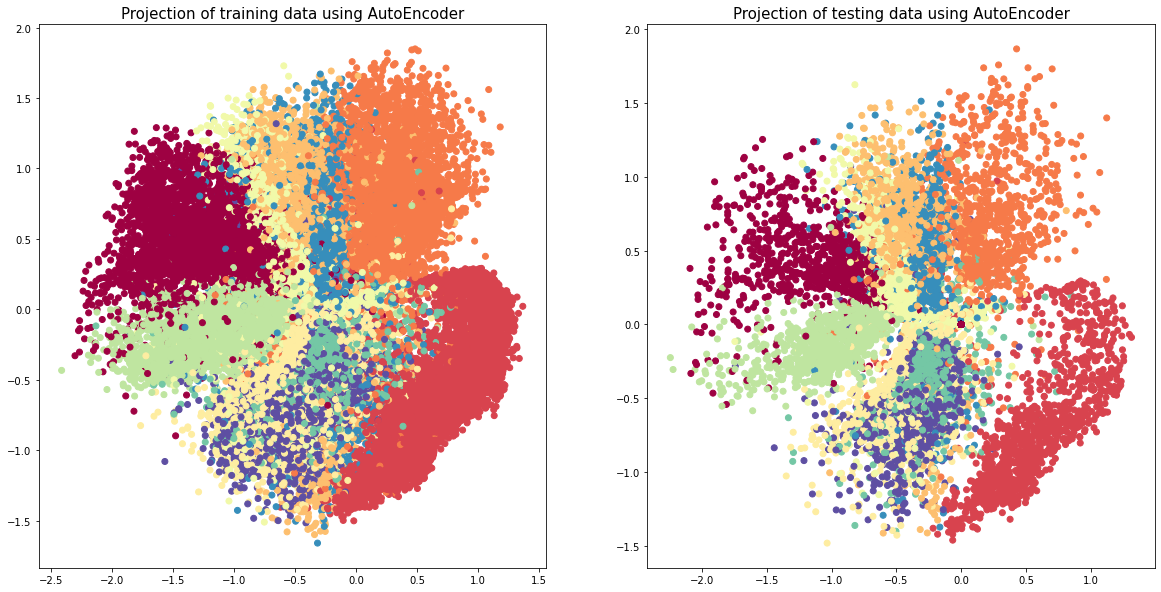

In [4]:
# ------------------------------ draw --------------------------

draw_train_data_list = np.zeros((len(train_data), 2))
draw_train_label_list = np.zeros((len(train_data)))

draw_test_data_list = np.zeros((len(train_data), 2))
draw_test_label_list = np.zeros((len(train_data)))

model.eval()
data_count = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.reshape(-1, 28*28).to(device)

        feature_vector = model.encoder_func(images).detach().cpu().numpy()

        draw_train_data_list[data_count:data_count+images.shape[0], :] = feature_vector.copy()
        draw_train_label_list[data_count:data_count+images.shape[0]] = labels.reshape(-1)

        data_count += images.shape[0]

data_count = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(test_data_loader):
        images = images.reshape(-1, 28*28).to(device)

        feature_vector = model.encoder_func(images).detach().cpu().numpy()

        draw_test_data_list[data_count:data_count+images.shape[0], :] = feature_vector.copy()
        draw_test_label_list[data_count:data_count+images.shape[0]] = labels.reshape(-1)

        data_count += images.shape[0]

# draw func
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(121)
plt.title("Projection of training data using AutoEncoder", fontsize=15)
ax.scatter(draw_train_data_list[:, 0], draw_train_data_list[:, 1], c=draw_train_label_list, cmap=plt.cm.Spectral)

ax = fig.add_subplot(122)
plt.title("Projection of testing data using AutoEncoder", fontsize=15)
ax.scatter(draw_test_data_list[:, 0], draw_test_data_list[:, 1], c=draw_test_label_list, cmap=plt.cm.Spectral)

plt.show()
